# Human Research

In [1]:
from constants import all_topics_names, folder_meicogsci, folder_meicogsci_2019, folder_models
from helping_functions import get_topics_for_abstract
import matplotlib.pyplot as plt
import collections
import networkx
import gensim
import pandas
import nltk
import os

In [2]:
lem = nltk.stem.WordNetLemmatizer()

In [3]:
# get list of abstracts
all_files = os.listdir(folder_meicogsci)
all_files_2019 = os.listdir(folder_meicogsci_2019)

In [4]:
# get the model
model_21 = gensim.models.LdaModel.load(os.path.join(folder_models, "LDA_21"))
model_21.minimum_probability = 0.0

In [5]:
#function for preprocessing data
def preprocessing_data(folder, file_list):
    all_files_by_topic = []
    subject_files = []
    participant_files = []
    for filename in all_files:
        with open(os.path.join(folder_meicogsci, filename)) as f:
            data = f.readlines()
            title = data[0].replace("... title: ", "").replace("\n", " ")
            data = " ".join(data).replace("... title: ", "").replace("\n", " ")
        data = data.lower()
        data_tok = nltk.tokenize.word_tokenize(data)
        if "subjects" in data_tok:
            subject_files.append(filename)
        if "participants" in data_tok:
            participant_files.append(filename)
        data_tok = [lem.lemmatize(w) for w in data_tok]
        doc_topics, _, _ = model_21.get_document_topics(model_21.id2word.doc2bow(data_tok), per_word_topics=True)
        doc_topics = dict(doc_topics)
        new_row = []
        for i in range(21):
            if i in doc_topics:
                new_row.append(doc_topics[i])
            else:
                new_row.append(0)
        new_row.append(filename)
        new_row.append(title)
        all_files_by_topic.append(new_row)
    return all_files_by_topic, subject_files, participant_files

In [6]:
# get the data
all_files_by_topic = []
subject_files = []
participant_files = []
for folder, list_of_files in [[folder_meicogsci, all_files], [folder_meicogsci_2019, all_files_2019]]:
    current_files_by_topic, current_subject_files, current_participant_files = preprocessing_data(folder, list_of_files)
    all_files_by_topic += current_files_by_topic
    subject_files += current_subject_files
    participant_files += current_participant_files

In [7]:
# all abstracts that use the word subjects
subject_files_set = set([filename.split("_")[2].split(".")[0] for filename in subject_files])

In [8]:
# all abstracts that use the word participants
participant_files_set = set([filename.split("_")[2].split(".")[0] for filename in participant_files])

In [9]:
# all abstracts
all_files_set = set([filename.split("_")[2].split(".")[0] for filename in all_files])

In [10]:
# see the files that use just one of the word, both or none
s_and_p_files = participant_files_set.intersection(subject_files_set)
s_only_files = subject_files_set.difference(participant_files_set)
p_only_files = participant_files_set.difference(subject_files_set)
other_files = all_files_set.difference(participant_files_set.union(subject_files_set))

In [11]:
# how many abstract use at least one word (they do experiments on humans)?
((len(s_and_p_files) + len(s_only_files) + len(p_only_files))/len(all_files))*100

49.596774193548384

In [12]:
# here I am calculating the the abstracts that use each word by topics
together = [0]*21
topics_by_type = dict()
for group in ["sp", "s", "p", "n"]:
    topics_by_type[group] = [0]*21
for abstract in all_files_by_topic:
    abstract_id = abstract[-2].split("_")[2].split(".")[0]
    topics = abstract[:-2]
    if abstract_id in s_and_p_files:
        topics_by_type["sp"] = [sum([i, j]) for i, j in zip(topics_by_type["sp"], topics)]
    if abstract_id in s_only_files:
        topics_by_type["s"] = [sum([i, j]) for i, j in zip(topics_by_type["s"], topics)]
    if abstract_id in p_only_files:
        topics_by_type["p"] = [sum([i, j]) for i, j in zip(topics_by_type["p"], topics)]
    if abstract_id in other_files:
        topics_by_type["n"] = [sum([i, j]) for i, j in zip(topics_by_type["n"], topics)]
    together = [sum([i, j]) for i, j in zip(together, topics)]

In [13]:
# here I am just putting it in the better form
for group in topics_by_type:
    if group == "sp":
        topics_by_type[group] = [i / (len(s_and_p_files)/len(all_files)) for i in topics_by_type[group]]
    if group == "s":
        topics_by_type[group] = [i / (len(s_only_files)/len(all_files)) for i in topics_by_type[group]]
    if group == "p":
        topics_by_type[group] = [i / (len(p_only_files)/len(all_files)) for i in topics_by_type[group]]
    if group == "n":
        topics_by_type[group] = [i / (len(other_files)/len(all_files)) for i in topics_by_type[group]]

In [14]:
# here I am renaming the columns
columns_rename = {"sp": "subjects and participants", "p": "participants only", "s": "subjects only", "n": "none"}
topics_by_experiment_pandas = pandas.DataFrame(topics_by_type).rename(index=all_topics_names, columns=columns_rename)

In [15]:
# here I am calculating the ratio of experiments with humans
topics_by_experiment_pandas["experiments"] = 1 - (topics_by_experiment_pandas["none"]/(topics_by_experiment_pandas["subjects and participants"] + topics_by_experiment_pandas["participants only"] + topics_by_experiment_pandas["subjects only"] + topics_by_experiment_pandas["none"]))

In [16]:
# here I can list the topics by how many human experimentation they do
topics_by_experiment_pandas[["experiments"]].sort_values(by="experiments", ascending=False)

,experiments
perception,0.915113
attention,0.895649
non-typical,0.889058
categorization,0.839996
neuroscience,0.818790
TMS,0.806771
decision making,0.800626
movement,0.791827
health,0.791650
learning,0.778934


In [17]:
# here I am calculating the ratio of use of subjects and participants words
topics_by_experiment_pandas["participants"] = topics_by_experiment_pandas["participants only"]/(topics_by_experiment_pandas["participants only"] + topics_by_experiment_pandas["subjects only"])
topics_by_experiment_pandas["subjects"] = topics_by_experiment_pandas["subjects only"]/(topics_by_experiment_pandas["participants only"] + topics_by_experiment_pandas["subjects only"])

In [18]:
# here are the results
topics_by_experiment_pandas[["participants", "subjects"]].sort_values(by="subjects")

,participants,subjects
tasks,0.770226,0.229774
language,0.749858,0.250142
decision making,0.690200,0.309800
attention,0.670435,0.329565
verbalization,0.604536,0.395464
constructivism,0.584983,0.415017
society,0.584423,0.415577
movement,0.528684,0.471316
perception,0.505274,0.494726
health,0.499092,0.500908


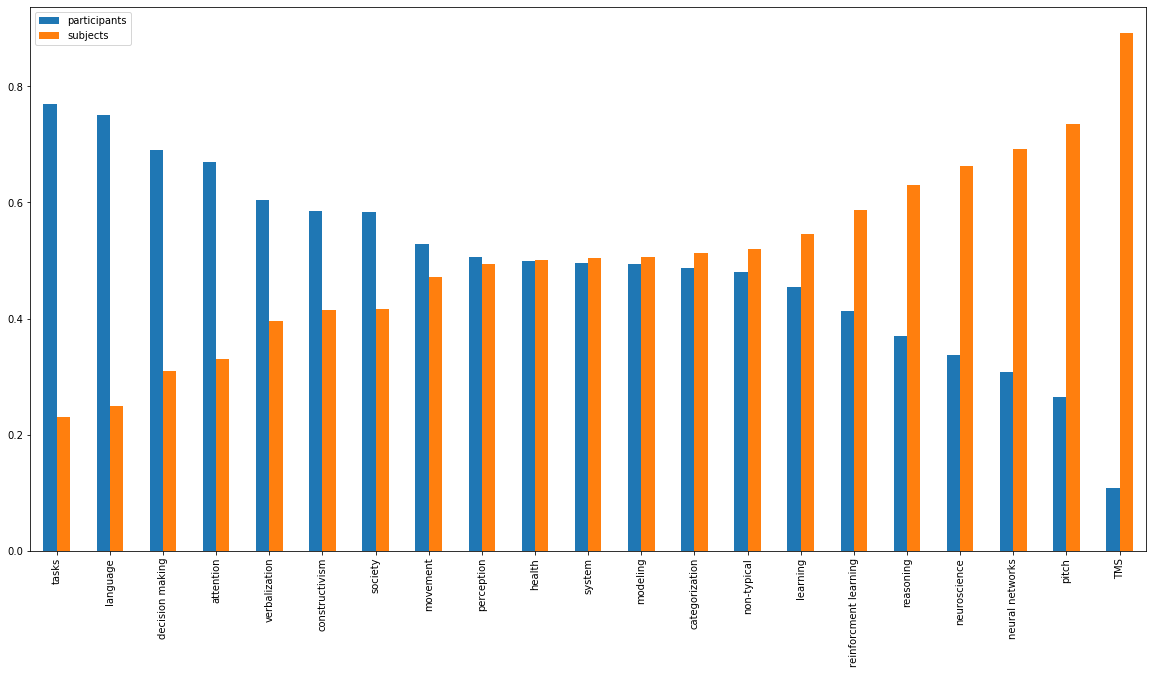

In [19]:
# here I am showing the ratio of the use of participant and subjects in each topic
topics_by_experiment_pandas[["participants", "subjects"]].sort_values(by="subjects").plot(kind="bar", figsize=(20, 10))

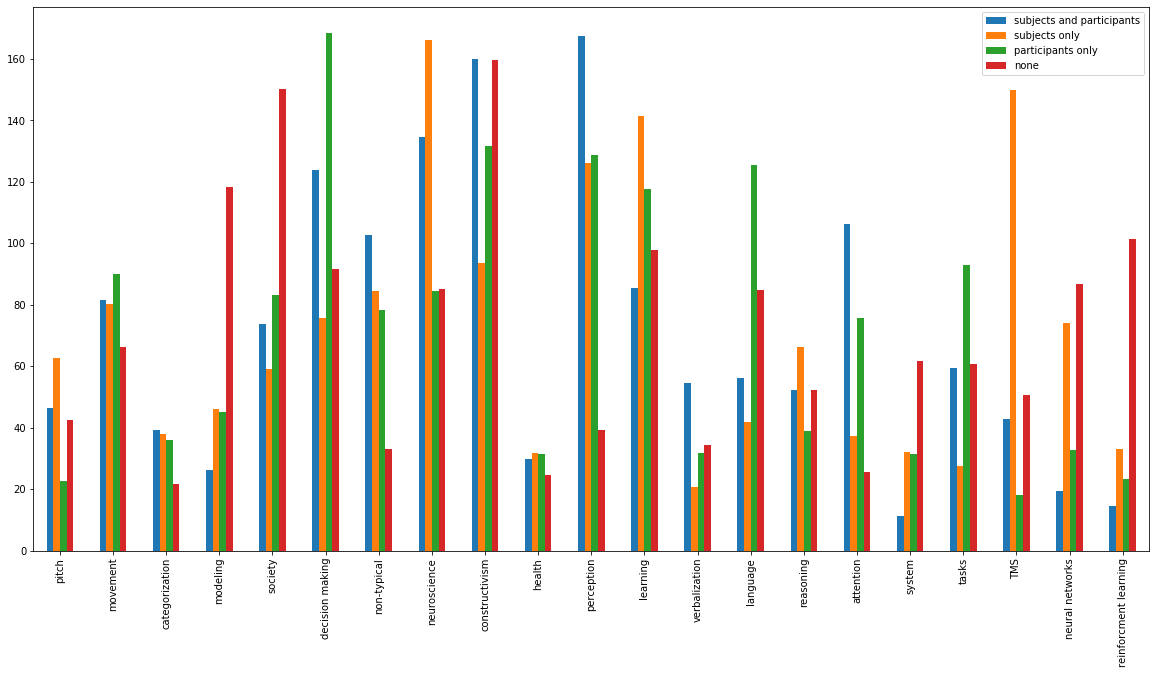

In [20]:
#and here it is showing of all four types, sorted by the number of abstracts
topics_by_experiment_pandas[["subjects and participants", "subjects only", "participants only", "none"]].plot(kind="bar", figsize=(20, 10))